A notebook for finetuning Stable Diffusion using LORA.

Tested with [Stable Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5).

Notebook developed by [pedrogengo](https://github.com/pedrogengo).

# SETUP

In [1]:
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && pip install /content/lora
!pip install accelerate bitsandbytes

fatal: destination path 'lora' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# TRAINING

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import shutil
from google.colab import files
from tqdm import tqdm

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
PROMPT="Chest X-ray" #@param{type: 'string'}

OUTPUT_DIR="/content/drive/MyDrive/Chest-X-ray-Generator/Outout" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="/content/drive/MyDrive/Chest-X-ray-Generator/dataloadertest" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL
  
  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

In [4]:
STEPS = 500 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 1 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 3e-4 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-6 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

2023-05-01 00:14:51.922902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[00:14:57] WARNING  The following values were not passed to        ]8;id=230942;file:///usr/local/lib/python3.10/dist-packages/accelerate/commands/launch.py\launch.py]8;;\:]8;id=536433;file:///usr/local/lib/python3.10/dist-packages/accelerate/commands/launch.py#895\895]8;;\
                    `accelerate launch` and had defaults used                   
                    instead:                                                    
                            `--num_processes` was set to a value                
                    of `1`                                                      
                            `--num_machines` was set to a value of              
                    `1`                                                         
                            `--mixed_precision` was set to a value              
                    of `'n

# INFERENCE

In [5]:
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [6]:
pipe.safety_checker = None

  0%|          | 0/50 [00:00<?, ?it/s]

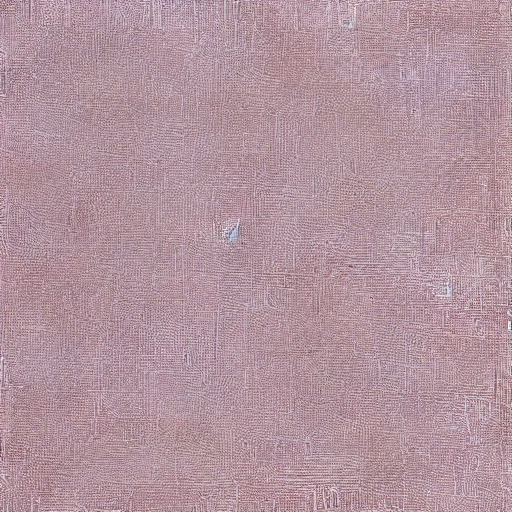

In [7]:
INFERENCE_PROMPT = 'heart' #@param {type:"string"}
LORA_SCALE_UNET = 0.1 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 0.1 #@param {type:"number"}
GUIDANCE = 1.4 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image